# Импорт библиотек

In [2]:
# based on https://www.kaggle.com/konstanter/fasterrcnn-pytorch-maskdetection

import numpy as np 
import pandas as pd 
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import os
import glob
import xml.etree.ElementTree as et

In [49]:
# import os
# import zipfile
    
# def zipdir(path, ziph):
#     # ziph is zipfile handle
#     for root, dirs, files in os.walk(path):
#         for file in files:
#             ziph.write(os.path.join(root, file), 
#                        os.path.relpath(os.path.join(root, file), 
#                                        os.path.join(path, '..')))

# with zipfile.ZipFile('./project_2.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
#     zipdir('project/', zipf)

# Загрузка данных в DataLoader

In [3]:
# путь к файлам
images_dir = './project/images/'
annotations_dir = './project/annotations/'


class FaceMaskDataset(torch.utils.data.Dataset):

    def __init__(self, images_dir, annotation_dir,width, height, transforms=None):
        self.transforms = transforms
        self.images_dir = images_dir
        self.annotation_dir = annotation_dir
        self.height = height
        self.width = width
        
        # сортировка изображений
        self.imgs = [image for image in sorted(os.listdir(images_dir))]
        self.annotate = [image for image in sorted(os.listdir(annotation_dir))]
        
        # на 0й позиции находится фон
        self.classes = [_, 'without_mask','with_mask','mask_weared_incorrect']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.images_dir, img_name)

        # изменение цвета и размера изображения    
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # нормализация изображения
        img_res /= 255.0
        
        # аннотация
        annot_filename = self.annotate[idx]
        annot_file_path = os.path.join(self.annotation_dir, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # высота и ширина изобрадения
        wt = img.shape[1]
        ht = img.shape[0]
        
        # ограничивающие рамки
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))
            
            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            
            
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height

            if xmax_corr > self.width:
                xmax_corr = self.width
            if ymax_corr > self.height:
                ymax_corr = self.height
            
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        # перевод boxes в формат torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd

        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        print(annot_filename)
        if self.transforms:
            
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
        return img_res, target

    def __len__(self):
        return len(self.imgs)


# проверка датасета
dataset = FaceMaskDataset(images_dir, annotations_dir, 224, 224)
print('length of dataset = ', len(dataset), '\n')

img, target = dataset[78]
print('Image shape = ', img.shape, '\n','Target - ', target)

length of dataset =  853 

maksssksksss169.xml
Image shape =  (224, 224, 3) 
 Target -  {'boxes': tensor([[113.1163, 146.7200, 163.7209, 205.5200]]), 'labels': tensor([2]), 'area': tensor([2975.5537]), 'iscrowd': tensor([0]), 'image_id': tensor([78])}


maksssksksss13.xml


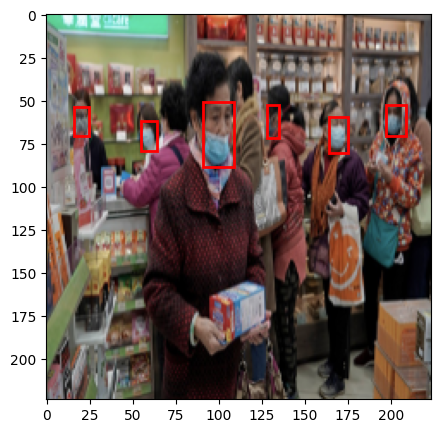

In [4]:
# Вспомогательная функция для визуализации bbox

def plot_img_bbox(img, target):
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Отрисуем bbox поверх картинки
        a.add_patch(rect)
    plt.show()
    
img, target = dataset[35]
plot_img_bbox(img, target)

In [5]:
def get_transform(train):
    
    if train:
        return A.Compose([
                            # A.HorizontalFlip(0.5),
                            # A.RandomBrightnessContrast(p=0.2),
                            # A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [6]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [7]:
img_size = 480
dataset = FaceMaskDataset(images_dir, annotations_dir, img_size, img_size, transforms= get_transform(train=True))
dataset_test = FaceMaskDataset(images_dir, annotations_dir, img_size, img_size, transforms= get_transform(train=False))

# разделим данные на train и test
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=False,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=2, shuffle=False,
    collate_fn=collate_fn)

# Обучение модели

In [8]:
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
   
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [9]:
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')

num_classes = 4

model = get_model_instance_segmentation(num_classes)

num_epochs = 5

model.to(device)


params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)
len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()         
        epoch_loss += losses.item()
    print('Epoch_loss = ',epoch_loss)


maksssksksss607.xml
maksssksksss811.xml


d:\ProgrammFiles\miniconda\envs\cv\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


maksssksksss525.xml
maksssksksss568.xml
maksssksksss59.xml
maksssksksss299.xml
maksssksksss772.xml
maksssksksss400.xml
maksssksksss163.xml
maksssksksss261.xml
maksssksksss102.xml
maksssksksss183.xml
maksssksksss514.xml
maksssksksss455.xml
maksssksksss390.xml
maksssksksss205.xml
maksssksksss650.xml
maksssksksss370.xml
maksssksksss337.xml
maksssksksss540.xml
maksssksksss604.xml
maksssksksss785.xml
maksssksksss600.xml
maksssksksss177.xml
maksssksksss830.xml
maksssksksss478.xml
maksssksksss248.xml
maksssksksss768.xml
maksssksksss42.xml
maksssksksss44.xml
maksssksksss277.xml
maksssksksss717.xml
maksssksksss276.xml
maksssksksss383.xml
maksssksksss143.xml
maksssksksss10.xml
maksssksksss745.xml
maksssksksss201.xml
maksssksksss657.xml
maksssksksss599.xml
maksssksksss518.xml
maksssksksss817.xml
maksssksksss413.xml
maksssksksss482.xml
maksssksksss639.xml
maksssksksss633.xml
maksssksksss259.xml
maksssksksss174.xml
maksssksksss368.xml
maksssksksss427.xml
maksssksksss456.xml
maksssksksss659.xml
maks

In [10]:
# вспомогательная функция принимает исходный прогноз и порог iou

def apply_nms(orig_prediction, iou_thresh=0.3):
    
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

def torch_to_pil(img):
    return transforms.ToPILImage()(img).convert('RGB')

In [11]:
img, target = dataset_test[4]

model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

maksssksksss563.xml
predicted #boxes:  1
real #boxes:  1


EXPECTED OUTPUT


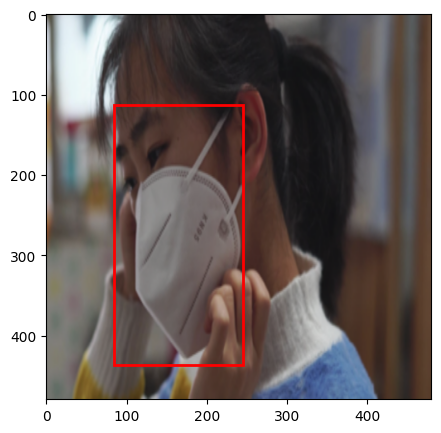

In [12]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)

MODEL OUTPUT


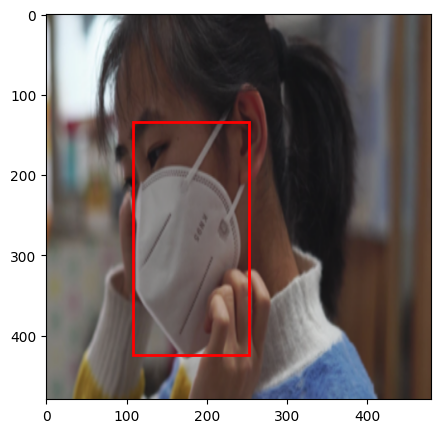

In [13]:
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction)

NMS APPLIED MODEL OUTPUT


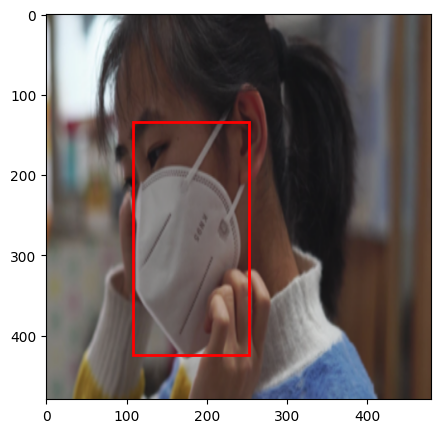

In [14]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), nms_prediction)

# Отрисовка изобрадений

In [26]:
def plot_image(img_tensor, annotation,predict=True):
    
    fig,ax = plt.subplots(1)
    fig.set_size_inches(18.5, 10.5)
    img = img_tensor.data
    mask_dic = {1:'without_mask', 2:'with_mask', 3:'mask_weared_incorrect'}

    ax.imshow(img.permute(1, 2, 0))
    
    for i,box in enumerate(annotation["boxes"]):
        xmin, ymin, xmax, ymax = box

        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        ax.add_patch(rect)
        label = mask_dic[int(annotation['labels'][i].data)]
        if predict:
            score = int((annotation['scores'][i].data) * 100)
            ax.text(xmin, ymin, f"{label} : {score}%", horizontalalignment='center', verticalalignment='center',fontsize=20,color='b')
        else:
            score=''
            ax.text(xmin, ymin, f"{label}", horizontalalignment='center', verticalalignment='center',fontsize=20,color='b')
    plt.show()

In [31]:
for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        break

maksssksksss607.xml
maksssksksss811.xml


In [28]:
model.eval()
preds = model(imgs)

Prediction


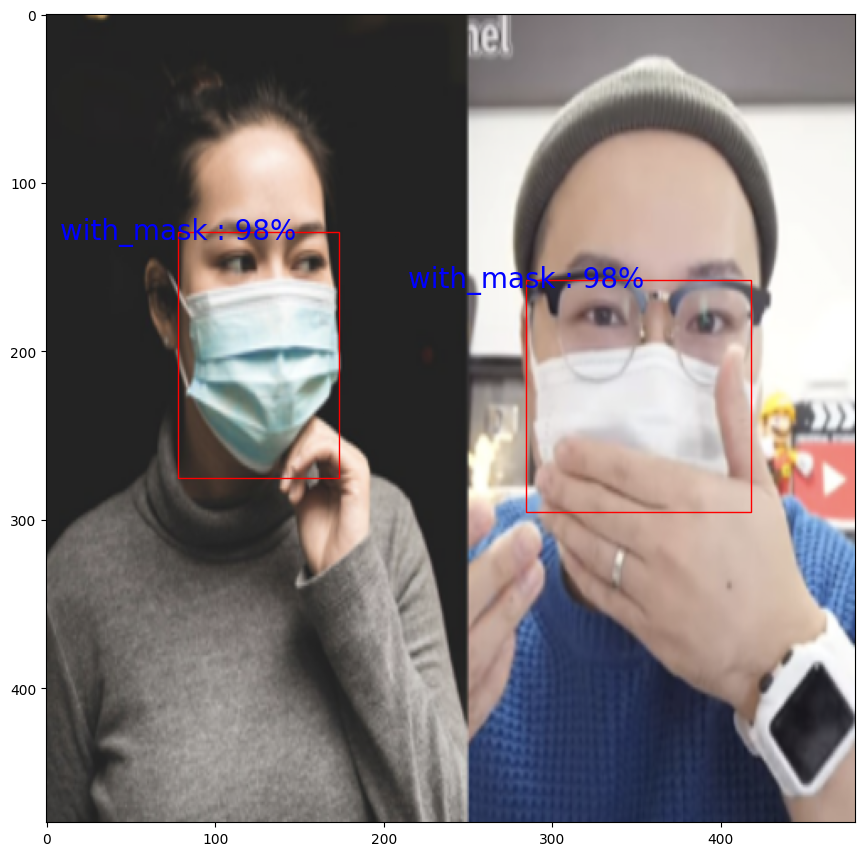

Target


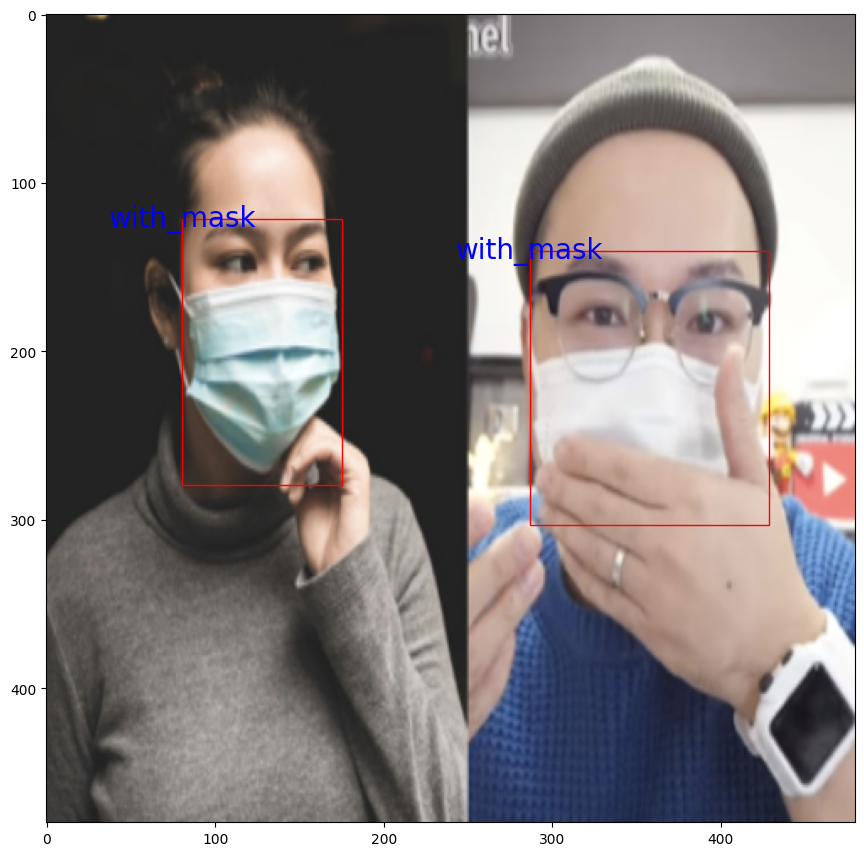

In [35]:
with torch.no_grad():
    nms_prediction = apply_nms(preds[0], iou_thresh=0.2)
    print("Prediction")
    plot_image(imgs[0].to('cpu'), nms_prediction)
    print("Target")
    plot_image(imgs[0].to('cpu'), annotations[0],False)

Prediction


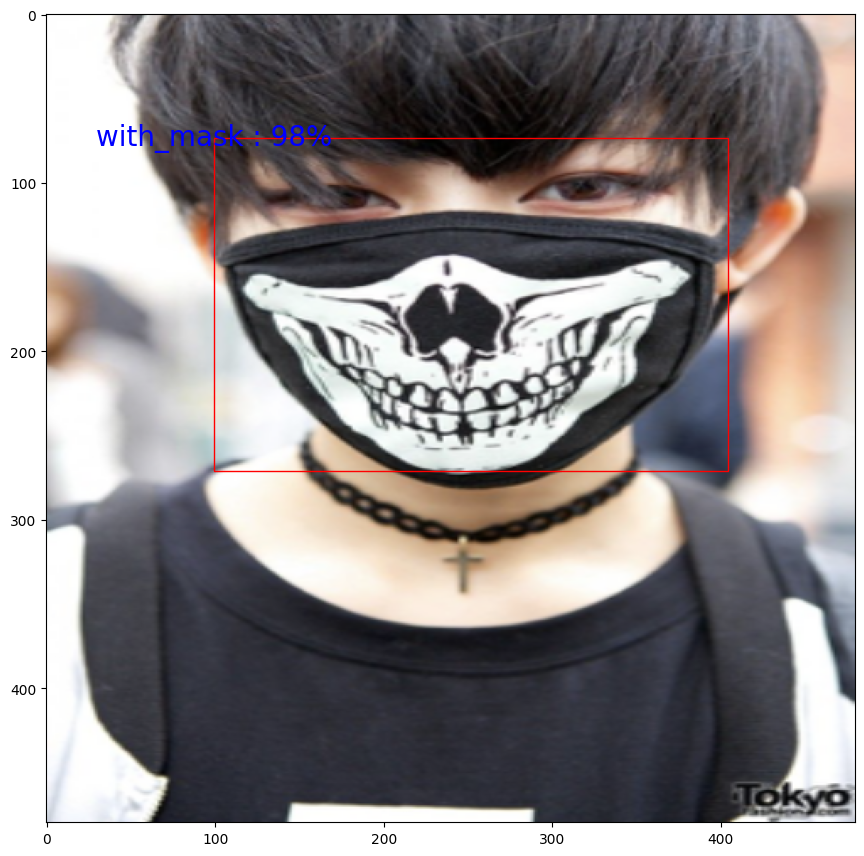

Target


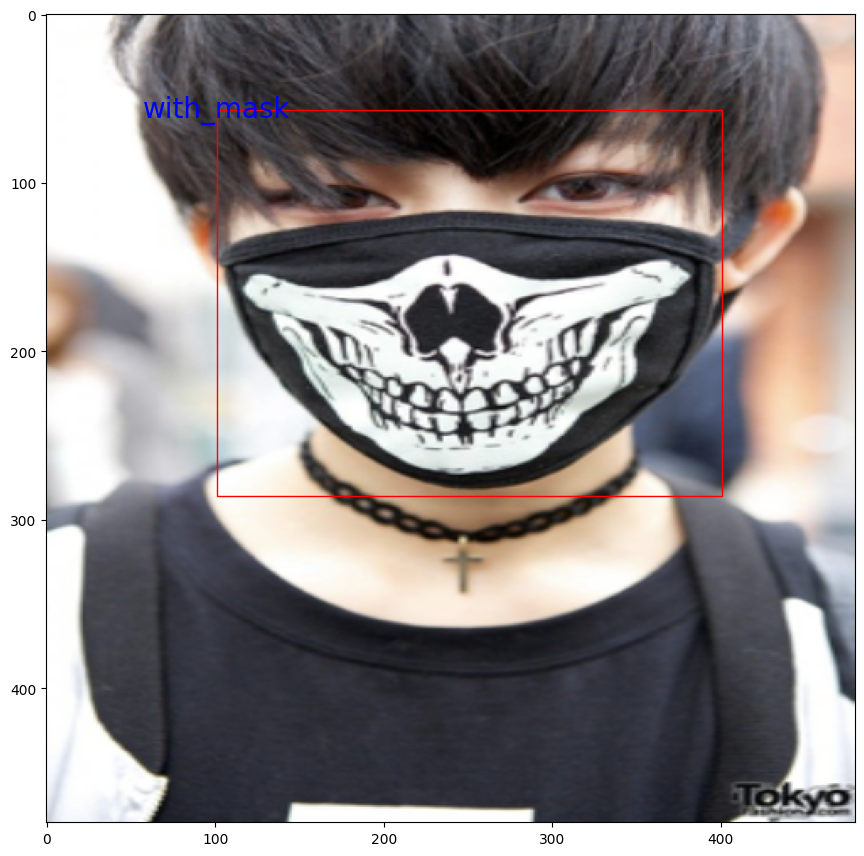

In [37]:
with torch.no_grad():
    nms_prediction = apply_nms(preds[1], iou_thresh=0.2)
    print("Prediction")
    plot_image(imgs[1], nms_prediction)
    print("Target")
    plot_image(imgs[1].to('cpu'), annotations[1],False)

In [1]:
# view at http://localhost:6006/
!tensorboard --logdir "./runs/train/"

^C
